## INSTALL DEPENDENCIES

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


## LOAD THE DATASET

In [3]:
import pandas as pd
import numpy as np
import os

# Define Country and the dataset path, can be changed for any country
country = "Australia"
base_path = r"C:\Users\Mugilkrishna D U\Desktop\Sugar-Production\main-dataset"
file_path = os.path.join(base_path, f"{country}_completed.csv")

df = pd.read_csv(file_path)

# Column name standardization
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

required_cols = [
    "year",
    "land_used(ha)",
    "sugarcane_yield(t/ha)",
    "sugar_prod(tons)",
    "exported_sugar(tons)"
]

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

# Sort the values by year, just for better structure
df = df.sort_values("year").reset_index(drop=True)

for col in required_cols[1:]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.replace("\xa0", "")
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [4]:
# Check for missing values
print("Missing values:\n", df[required_cols].isnull().sum())

Missing values:
 year                     0
land_used(ha)            0
sugarcane_yield(t/ha)    0
sugar_prod(tons)         0
exported_sugar(tons)     0
dtype: int64


In [5]:
# Dataset info
print("\nDataset Info:")
df[required_cols].info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   63 non-null     int64  
 1   land_used(ha)          63 non-null     int64  
 2   sugarcane_yield(t/ha)  63 non-null     float64
 3   sugar_prod(tons)       63 non-null     int64  
 4   exported_sugar(tons)   63 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 2.6 KB


In [6]:
# Displaying first 5 rows
df[required_cols].head()

,year,land_used(ha),sugarcane_yield(t/ha),sugar_prod(tons),exported_sugar(tons)
0,1961,156521,62.166103,9730296,3289520.0
1,1962,162514,79.625800,12940301,3300140.0
2,1963,168981,72.863600,12312569,3289520.0
3,1964,190355,80.441110,15312357,3298580.0
4,1965,203635,70.627500,14382227,3289520.0


## CREATE SLIDING WINDOW

In [7]:
import numpy as np
import pandas as pd

def create_sliding_windows(df: pd.DataFrame,
                           feature_cols: list,
                           target_cols: list,
                           window_size: int = 5,
                           forecast_horizon: int = 1,
                           return_index: bool = False):
    """
    Generate sliding windows for multivariate time series forecasting.
    Args:
        df (pd.DataFrame): DataFrame sorted by time
        feature_cols (list): List of input feature column names
        target_cols (list): List of target variable column names
        window_size (int): Number of past time steps to use as input
        forecast_horizon (int): Steps ahead to predict (default=1)
        return_index (bool): Whether to return target indices/timestamps

    Returns:
        X (np.ndarray): shape (samples, window_size, num_features)
        y (np.ndarray): shape (samples, num_targets)
        (Optional) index (pd.Series): index of predicted y values
    """
    X, y, idx = [], [], []

    for i in range(window_size, len(df) - forecast_horizon + 1):
        window = df[feature_cols].iloc[i - window_size:i].values
        target = df[target_cols].iloc[i + forecast_horizon - 1].values

        if np.isnan(window).any() or np.isnan(target).any():
            continue

        X.append(window)
        y.append(target)
        idx.append(df.index[i + forecast_horizon - 1])

    X = np.array(X)
    y = np.array(y)

    if return_index:
        return X, y, pd.Series(idx, name="target_index")

    return X, y


In [8]:
window_size = 5  # this is basically the number of time steps for the input sequence

# Define the input and target columns, in this case both are same 
input_cols = ["land_used(ha)", "sugarcane_yield(t/ha)", "sugar_prod(tons)", "exported_sugar(tons)"]
target_cols = input_cols  

# Sliding windows for RNNs
X, y, y_idx = create_sliding_windows(
    df,
    feature_cols=input_cols,
    target_cols=target_cols,
    window_size=window_size,
    forecast_horizon=1,
    return_index=True
)

print(f"Input shape: {X.shape} | Output shape: {y.shape}")
print(f"Forecast window spans: {df['year'].iloc[y_idx.index[0]]} → {df['year'].iloc[y_idx.index[-1]]}")


Input shape: (58, 5, 4) | Output shape: (58, 4)
Forecast window spans: 1961 → 2018


## EVALUATION METRICS

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# Normalize features & targets
input_scaler = StandardScaler()
target_scaler = StandardScaler()

X_scaled = input_scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
y_scaled = target_scaler.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Metric functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy_rate(y_true, y_pred):
    return np.mean(1 - np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Train results and prediction
results_train = {}
predictions_train = {}

# Test results and prediction
results = {}
predictions = {}


## MODEL BUILDING (TRAIN)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Scikit-learn models and wrappers
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso

# Reshape, flatten and inverse transformations
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_orig = target_scaler.inverse_transform(y_train)
y_test_orig = target_scaler.inverse_transform(y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
svm = MultiOutputRegressor(SVR(kernel='rbf', C=100, epsilon=0.1))
en = MultiOutputRegressor(ElasticNet(alpha=1.0, l1_ratio=0.5))
lasso = MultiOutputRegressor(Lasso(alpha=0.1))
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42))
bagging = BaggingRegressor(n_estimators=100, random_state=42)

# LSTM
def train_rnn(model_type):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "GRU":
        model.add(GRU(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
    return model

model_lstm = train_rnn("LSTM")
y_pred_lstm = target_scaler.inverse_transform(model_lstm.predict(X_train))
results_train['LSTM'] = {
    "RMSE": rmse(target_scaler.inverse_transform(y_train), y_pred_lstm),
    "MAPE": mape(target_scaler.inverse_transform(y_train), y_pred_lstm),
    "AC": accuracy_rate(target_scaler.inverse_transform(y_train), y_pred_lstm)
}
predictions_train['LSTM'] = y_pred_lstm

# GRU
model_gru = train_rnn("GRU")
y_pred_gru = target_scaler.inverse_transform(model_gru.predict(X_train))
results_train['GRU'] = {
    "RMSE": rmse(target_scaler.inverse_transform(y_train), y_pred_gru),
    "MAPE": mape(target_scaler.inverse_transform(y_train), y_pred_gru),
    "AC": accuracy_rate(target_scaler.inverse_transform(y_train), y_pred_gru)
}
predictions_train['GRU'] = y_pred_gru

# Random Forest
rf.fit(X_train_flat, y_train_orig)
y_pred_rf = rf.predict(X_train_flat)
results_train['RandomForest'] = {
    "RMSE": rmse(y_train_orig, y_pred_rf),
    "MAPE": mape(y_train_orig, y_pred_rf),
    "AC": accuracy_rate(y_train_orig, y_pred_rf)
}
predictions_train['RandomForest'] = y_pred_rf

# XGBoost
xgb_model.fit(X_train_flat, y_train_orig)
y_pred_xgb = xgb_model.predict(X_train_flat)
results_train['XGBoost'] = {
    "RMSE": rmse(y_train_orig, y_pred_xgb),
    "MAPE": mape(y_train_orig, y_pred_xgb),
    "AC": accuracy_rate(y_train_orig, y_pred_xgb)
}
predictions_train['XGBoost'] = y_pred_xgb

# IOMN-style Regularized TF model
def build_iomn_tf(input_shape, hidden_size=32, dense_size=16, dropout_rate=0.3, l2_lambda=1e-4):
    model = Sequential()
    model.add(LSTM(hidden_size, activation='tanh', input_shape=input_shape,
                   kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_size, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model

model_iomn_tf = build_iomn_tf(input_shape=(X_train.shape[1], X_train.shape[2]))
model_iomn_tf.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0,
                  callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
y_pred_iomn_tf = target_scaler.inverse_transform(model_iomn_tf.predict(X_train))
results_train["IOMN"] = {
    "RMSE": rmse(y_train_orig, y_pred_iomn_tf),
    "MAPE": mape(y_train_orig, y_pred_iomn_tf),
    "AC": accuracy_rate(y_train_orig, y_pred_iomn_tf)
}
predictions_train["IOMN"] = y_pred_iomn_tf

# SVR
svm.fit(X_train_flat, y_train_orig)
y_pred_svm = svm.predict(X_train_flat)
results_train["SVR"] = {
    "RMSE": rmse(y_train_orig, y_pred_svm),
    "MAPE": mape(y_train_orig, y_pred_svm),
    "AC": accuracy_rate(y_train_orig, y_pred_svm)
}
predictions_train["SVR"] = y_pred_svm

# Extra Trees
et.fit(X_train_flat, y_train_orig)
y_pred_et = et.predict(X_train_flat)
results_train["Extra Tree"] = {
    "RMSE": rmse(y_train_orig, y_pred_et),
    "MAPE": mape(y_train_orig, y_pred_et),
    "AC": accuracy_rate(y_train_orig, y_pred_et)
}
predictions_train["Extra Tree"] = y_pred_et

# Elastic Net
en.fit(X_train_flat, y_train_orig)
y_pred_en = en.predict(X_train_flat)
results_train["ElasticNet"] = {
    "RMSE": rmse(y_train_orig, y_pred_en),
    "MAPE": mape(y_train_orig, y_pred_en),
    "AC": accuracy_rate(y_train_orig, y_pred_en)
}
predictions_train["ElasticNet"] = y_pred_en

# LASSO
lasso.fit(X_train_flat, y_train_orig)
y_pred_lasso = lasso.predict(X_train_flat)
results_train["LASSO"] = {
    "RMSE": rmse(y_train_orig, y_pred_lasso),
    "MAPE": mape(y_train_orig, y_pred_lasso),
    "AC": accuracy_rate(y_train_orig, y_pred_lasso)
}
predictions_train["LASSO"] = y_pred_lasso

# Bagging Regressor
bagging.fit(X_train_flat, y_train_orig)
y_pred_bagging = bagging.predict(X_train_flat)
results_train['Bagging'] = {
    "RMSE": rmse(y_train_orig, y_pred_bagging),
    "MAPE": mape(y_train_orig, y_pred_bagging),
    "AC": accuracy_rate(y_train_orig, y_pred_bagging)
}
predictions_train['Bagging'] = y_pred_bagging

c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002536FC8FB00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.057e+09, tolerance: 2.212e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.839e+13, tolerance: 2.391e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

In [11]:
# Display final results
print('Results sorted by MAPE')
df_results_train = pd.DataFrame(results_train).T.sort_values("MAPE")
display(df_results_train.round(4))

print('Results sorted by AC')
df_results_train_AC = pd.DataFrame(results_train).T.sort_values("AC", ascending=False)
display(df_results_train_AC.round(4))

Results sorted by MAPE


,RMSE,MAPE,AC
Extra Tree,0.000000e+00,0.0000,100.0000
XGBoost,1.549400e+00,0.0001,99.9999
Bagging,4.844103e+05,1.8049,98.1951
RandomForest,5.202648e+05,1.8977,98.1023
LASSO,9.242558e+05,3.8987,96.1013
ElasticNet,1.348523e+06,5.1594,94.8406
GRU,1.896629e+06,6.8312,93.1688
LSTM,2.067805e+06,8.7854,91.2146
IOMN,2.682757e+06,10.3772,89.6228
SVR,3.770197e+06,11.2689,88.7311


Results sorted by AC


,RMSE,MAPE,AC
Extra Tree,0.000000e+00,0.0000,100.0000
XGBoost,1.549400e+00,0.0001,99.9999
Bagging,4.844103e+05,1.8049,98.1951
RandomForest,5.202648e+05,1.8977,98.1023
LASSO,9.242558e+05,3.8987,96.1013
ElasticNet,1.348523e+06,5.1594,94.8406
GRU,1.896629e+06,6.8312,93.1688
LSTM,2.067805e+06,8.7854,91.2146
IOMN,2.682757e+06,10.3772,89.6228
SVR,3.770197e+06,11.2689,88.7311


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df_plot_train = df_results_train.round(2).reset_index().rename(columns={"index": "Model"})

sns.set(style="whitegrid", font_scale=1.1)

def plot_horizontal_bar(data, x, y, title, palette, xlabel):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("")
    
    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
    
    plt.tight_layout()
    plt.show()

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


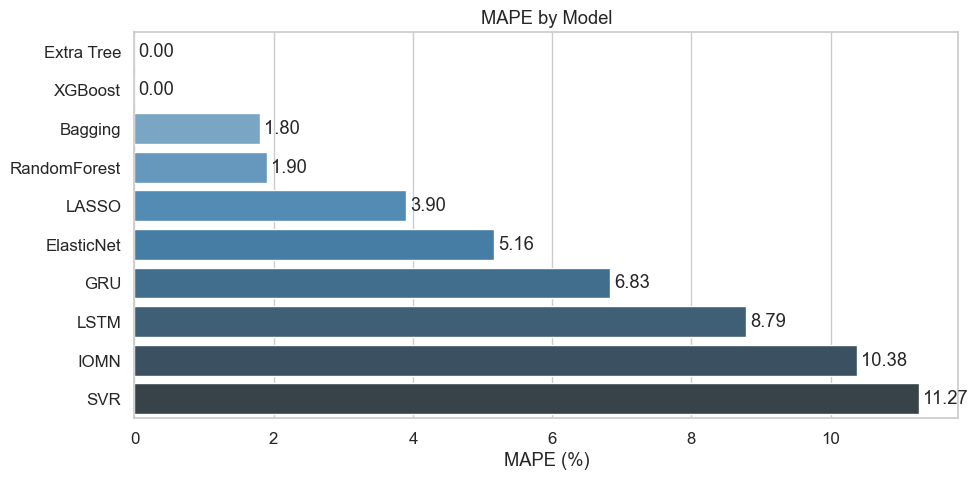

In [13]:
# Plot MAPE
plot_horizontal_bar(df_plot_train, x="MAPE", y="Model", title="MAPE by Model", palette="Blues_d", xlabel="MAPE (%)")

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


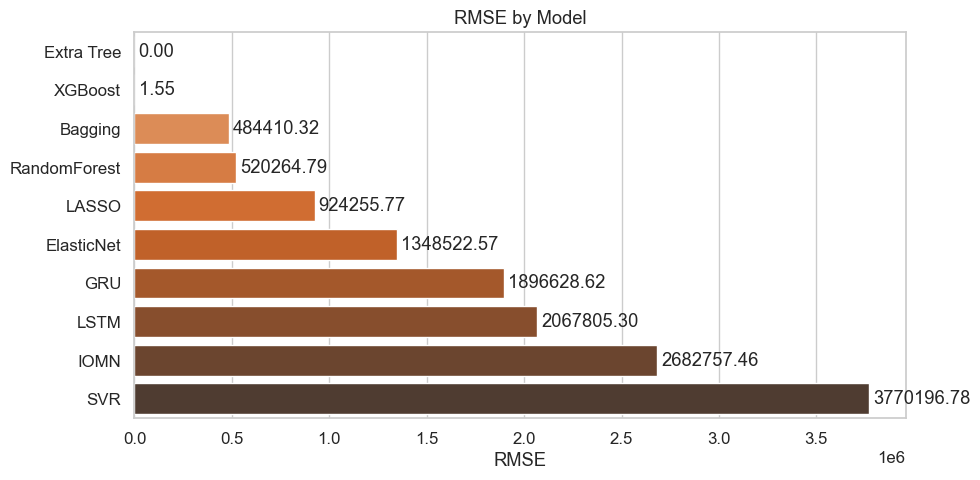

In [14]:
# Plot RMSE
plot_horizontal_bar(df_plot_train, x="RMSE", y="Model", title="RMSE by Model", palette="Oranges_d", xlabel="RMSE")

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


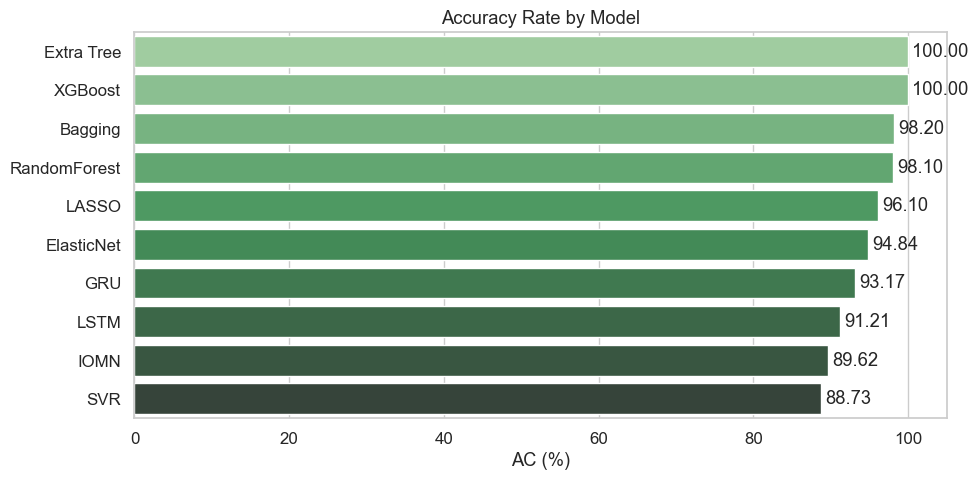

In [15]:
# Plot Accuracy Rate(AC)
# AC = 1 - MAPE
plot_horizontal_bar(df_plot_train, x="AC", y="Model", title="Accuracy Rate by Model", palette="Greens_d", xlabel="AC (%)")

## MODEL BUILDING (TEST)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Scikit-learn models and wrappers
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso

# LSTM
def train_rnn(model_type="LSTM"):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == "GRU":
        model.add(GRU(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
    return model

model_lstm = train_rnn("LSTM")
y_pred_lstm = target_scaler.inverse_transform(model_lstm.predict(X_test))
results['LSTM'] = {
    "RMSE": rmse(target_scaler.inverse_transform(y_test), y_pred_lstm),
    "MAPE": mape(target_scaler.inverse_transform(y_test), y_pred_lstm),
    "AC": accuracy_rate(target_scaler.inverse_transform(y_test), y_pred_lstm)
}
predictions['LSTM'] = y_pred_lstm

# GRU
model_gru = train_rnn("GRU")
y_pred_gru = target_scaler.inverse_transform(model_gru.predict(X_test))
results['GRU'] = {
    "RMSE": rmse(target_scaler.inverse_transform(y_test), y_pred_gru),
    "MAPE": mape(target_scaler.inverse_transform(y_test), y_pred_gru),
    "AC": accuracy_rate(target_scaler.inverse_transform(y_test), y_pred_gru)
}
predictions['GRU'] = y_pred_gru

# Tree-based & MLP (flattened input)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_train_orig = target_scaler.inverse_transform(y_train)
y_test_orig = target_scaler.inverse_transform(y_test)

# Random Forest
rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
rf.fit(X_train_flat, y_train_orig)
y_pred_rf = rf.predict(X_test_flat)
results['RandomForest'] = {
    "RMSE": rmse(y_test_orig, y_pred_rf),
    "MAPE": mape(y_test_orig, y_pred_rf),
    "AC": accuracy_rate(y_test_orig, y_pred_rf)
}
predictions['RandomForest'] = y_pred_rf

# XGBoost
xgb = MultiOutputRegressor(XGBRegressor(random_state=42, verbosity=0))
xgb.fit(X_train_flat, y_train_orig)
y_pred_xgb = xgb.predict(X_test_flat)
results['XGBoost'] = {
    "RMSE": rmse(y_test_orig, y_pred_xgb),
    "MAPE": mape(y_test_orig, y_pred_xgb),
    "AC": accuracy_rate(y_test_orig, y_pred_xgb)
}
predictions['XGBoost'] = y_pred_xgb

# IOMN-style Regularized TF model
def build_iomn_tf(input_shape, hidden_size=32, dense_size=16, dropout_rate=0.3, l2_lambda=1e-4):
    model = Sequential()
    model.add(LSTM(hidden_size, activation='tanh', input_shape=input_shape,
                   kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_size, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model

model_iomn_tf = build_iomn_tf(input_shape=(X_train.shape[1], X_train.shape[2]))
model_iomn_tf.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0,
                  callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
y_pred_iomn_tf = target_scaler.inverse_transform(model_iomn_tf.predict(X_test))
results["IOMN"] = {
    "RMSE": rmse(y_test_orig, y_pred_iomn_tf),
    "MAPE": mape(y_test_orig, y_pred_iomn_tf),
    "AC": accuracy_rate(y_test_orig, y_pred_iomn_tf)
}
predictions["IOMN"] = y_pred_iomn_tf

# SVR
svm = MultiOutputRegressor(SVR(kernel='rbf'))
svm.fit(X_train_flat, y_train_orig)
y_pred_svm = svm.predict(X_test_flat)
results["SVR"] = {
    "RMSE": rmse(y_test_orig, y_pred_svm),
    "MAPE": mape(y_test_orig, y_pred_svm),
    "AC": accuracy_rate(y_test_orig, y_pred_svm)
}
predictions["SVR"] = y_pred_svm

# Extra Trees
et = MultiOutputRegressor(ExtraTreesRegressor(random_state=42))
et.fit(X_train_flat, y_train_orig)
y_pred_et = et.predict(X_test_flat)
results["Extra Trees"] = {
    "RMSE": rmse(y_test_orig, y_pred_et),
    "MAPE": mape(y_test_orig, y_pred_et),
    "AC": accuracy_rate(y_test_orig, y_pred_et)
}
predictions["Extra Trees"] = y_pred_et

# Elastic Net
en = MultiOutputRegressor(ElasticNet(random_state=42))
en.fit(X_train_flat, y_train_orig)
y_pred_en = en.predict(X_test_flat)
results["ElasticNet"] = {
    "RMSE": rmse(y_test_orig, y_pred_en),
    "MAPE": mape(y_test_orig, y_pred_en),
    "AC": accuracy_rate(y_test_orig, y_pred_en)
}
predictions["ElasticNet"] = y_pred_en

# LASSO
lasso = MultiOutputRegressor(Lasso(random_state=42))
lasso.fit(X_train_flat, y_train_orig)
y_pred_lasso = lasso.predict(X_test_flat)
results["LASSO"] = {
    "RMSE": rmse(y_test_orig, y_pred_lasso),
    "MAPE": mape(y_test_orig, y_pred_lasso),
    "AC": accuracy_rate(y_test_orig, y_pred_lasso)
}
predictions["LASSO"] = y_pred_lasso

# ENSEMBLE METHODS
# Bagging Regressor
bagging = MultiOutputRegressor(BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=100,
    random_state=42
))
bagging.fit(X_train_flat, y_train_orig)
y_pred_bagging = bagging.predict(X_test_flat)
results['Bagging'] = {
    "RMSE": rmse(y_test_orig, y_pred_bagging),
    "MAPE": mape(y_test_orig, y_pred_bagging),
    "AC": accuracy_rate(y_test_orig, y_pred_bagging)
    #"R2": r2(y_test_orig, y_pred_bagging)
}
predictions['Bagging'] = y_pred_bagging

c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e+09, tolerance: 2.212e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.832e+13, tolerance: 2.391e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

In [17]:
# Blending models - XGB, RF, Bagging
# Simple blend: 50% XGB, 25% RF, 25% Bagging
y_pred_blend = 0.5 * y_pred_xgb + 0.25 * y_pred_rf + 0.25 * y_pred_bagging

results["Blending"] = {
    "RMSE": rmse(y_test_orig, y_pred_blend),
    "MAPE": mape(y_test_orig, y_pred_blend),
    "AC": accuracy_rate(y_test_orig, y_pred_blend)
}
predictions["Blending"] = y_pred_blend

In [18]:
# Display final results
print('Results sorted by MAPE')
df_results = pd.DataFrame(results).T.sort_values("MAPE")
display(df_results.round(4))

print('Results sorted by AC')
df_results = pd.DataFrame(results).T.sort_values("AC", ascending=False)
display(df_results.round(4))

Results sorted by MAPE


,RMSE,MAPE,AC
Blending,1.427009e+06,6.5468,93.4532
XGBoost,1.576817e+06,6.5856,93.4144
RandomForest,1.357116e+06,6.8133,93.1867
Bagging,1.402114e+06,6.9567,93.0433
ElasticNet,1.583861e+06,7.3142,92.6858
Extra Trees,1.479559e+06,7.3916,92.6084
IOMN,2.158648e+06,8.5536,91.4464
GRU,1.945483e+06,8.9971,91.0029
LSTM,2.411548e+06,9.1355,90.8645
SVR,3.486365e+06,12.0036,87.9964


Results sorted by AC


,RMSE,MAPE,AC
Blending,1.427009e+06,6.5468,93.4532
XGBoost,1.576817e+06,6.5856,93.4144
RandomForest,1.357116e+06,6.8133,93.1867
Bagging,1.402114e+06,6.9567,93.0433
ElasticNet,1.583861e+06,7.3142,92.6858
Extra Trees,1.479559e+06,7.3916,92.6084
IOMN,2.158648e+06,8.5536,91.4464
GRU,1.945483e+06,8.9971,91.0029
LSTM,2.411548e+06,9.1355,90.8645
SVR,3.486365e+06,12.0036,87.9964


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df_plot_test = df_results.round(2).reset_index().rename(columns={"index": "Model"})

sns.set(style="whitegrid", font_scale=1.1)

def plot_horizontal_bar_test(data, x, y, title, palette, xlabel):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("")
    
    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)
    
    plt.tight_layout()
    plt.show()

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


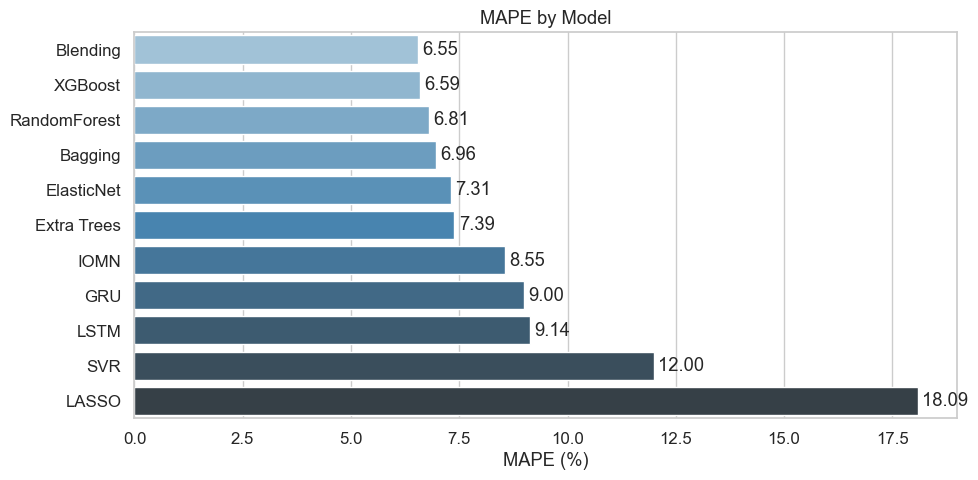

In [20]:
# Plot MAPE
plot_horizontal_bar(df_plot_test, x="MAPE", y="Model", title="MAPE by Model", palette="Blues_d", xlabel="MAPE (%)")

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


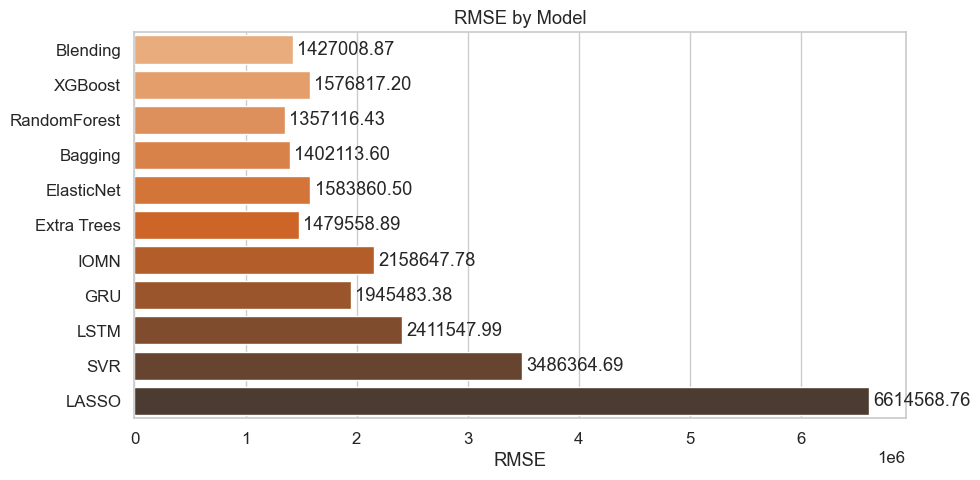

In [21]:
# Plot RMSE
plot_horizontal_bar(df_plot_test, x="RMSE", y="Model", title="RMSE by Model", palette="Oranges_d", xlabel="RMSE")

C:\Users\Mugilkrishna D U\AppData\Local\Temp\ipykernel_35000\906506008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x=x, y=y, palette=palette, orient='h')


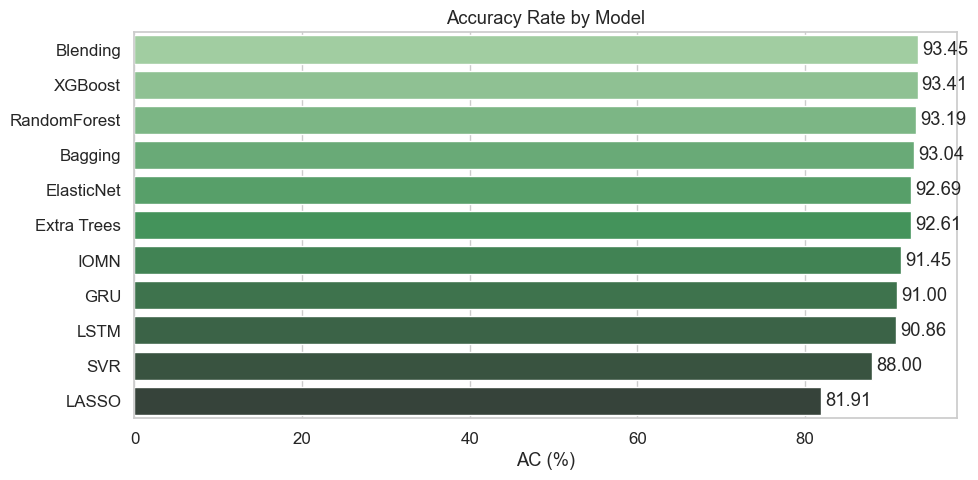

In [22]:
# Plot Accuracy Rate(AC)
# AC = 1 - MAPE
plot_horizontal_bar(df_plot_test, x="AC", y="Model", title="Accuracy Rate by Model", palette="Greens_d", xlabel="AC (%)")

## FORECASTING

In [23]:
# Forecasting parameters
forecast_years = 6
window_size = 5

# df["year"].max() = 2023, we have data till 2023
last_year = 2024

# Start window: last 5 years of raw data (not scaled yet)
future_input = df[input_cols].iloc[-window_size:].copy().values
future_years = []
predictions = []

# Scale the input window just once
future_input_scaled = input_scaler.transform(future_input)

for step in range(forecast_years):
    # Flatten and predict
    model_input = future_input_scaled.reshape(1, -1)  # XGBoost expects flat input
    y_next = xgb.predict(model_input)[0]

    # Save predicted values directly
    predictions.append(y_next)
    future_years.append(int(last_year + step + 1))

    # Update future_input with new prediction (raw, unscaled)
    future_input = np.vstack([future_input[1:], y_next])  # raw values

    # Re-scale new input for next iteration
    future_input_scaled = input_scaler.transform(future_input)

# Forecasted DataFrame
future_df = pd.DataFrame(predictions, columns=input_cols)
future_df["year"] = future_years
future_df["is_forecast"] = True

# Merge with historical
historical_df = df.copy()
historical_df["is_forecast"] = False

full_forecasted_df = pd.concat([historical_df, future_df], ignore_index=True)

# Display
print("\nForecasted Data (Last Few Rows):")
display(full_forecasted_df.tail(forecast_years + 2))


Forecasted Data (Last Few Rows):


,year,land_used(ha),sugarcane_yield(t/ha),sugar_prod(tons),exported_sugar(tons),is_forecast
61,2022,336003.00000,85.324500,28669280.0,3120000.00,False
62,2023,330456.00000,98.619510,32589392.0,3365660.00,False
63,2025,354663.75000,88.664413,37858328.0,3634374.25,True
64,2026,350291.21875,80.811478,34394956.0,3624653.75,True
65,2027,362408.25000,76.282257,33972912.0,3625187.25,True
66,2028,358096.96875,73.067047,28328342.0,3629298.50,True
67,2029,321122.59375,76.561562,28268366.0,2985843.25,True
68,2030,336329.62500,82.724808,30209722.0,3346189.25,True


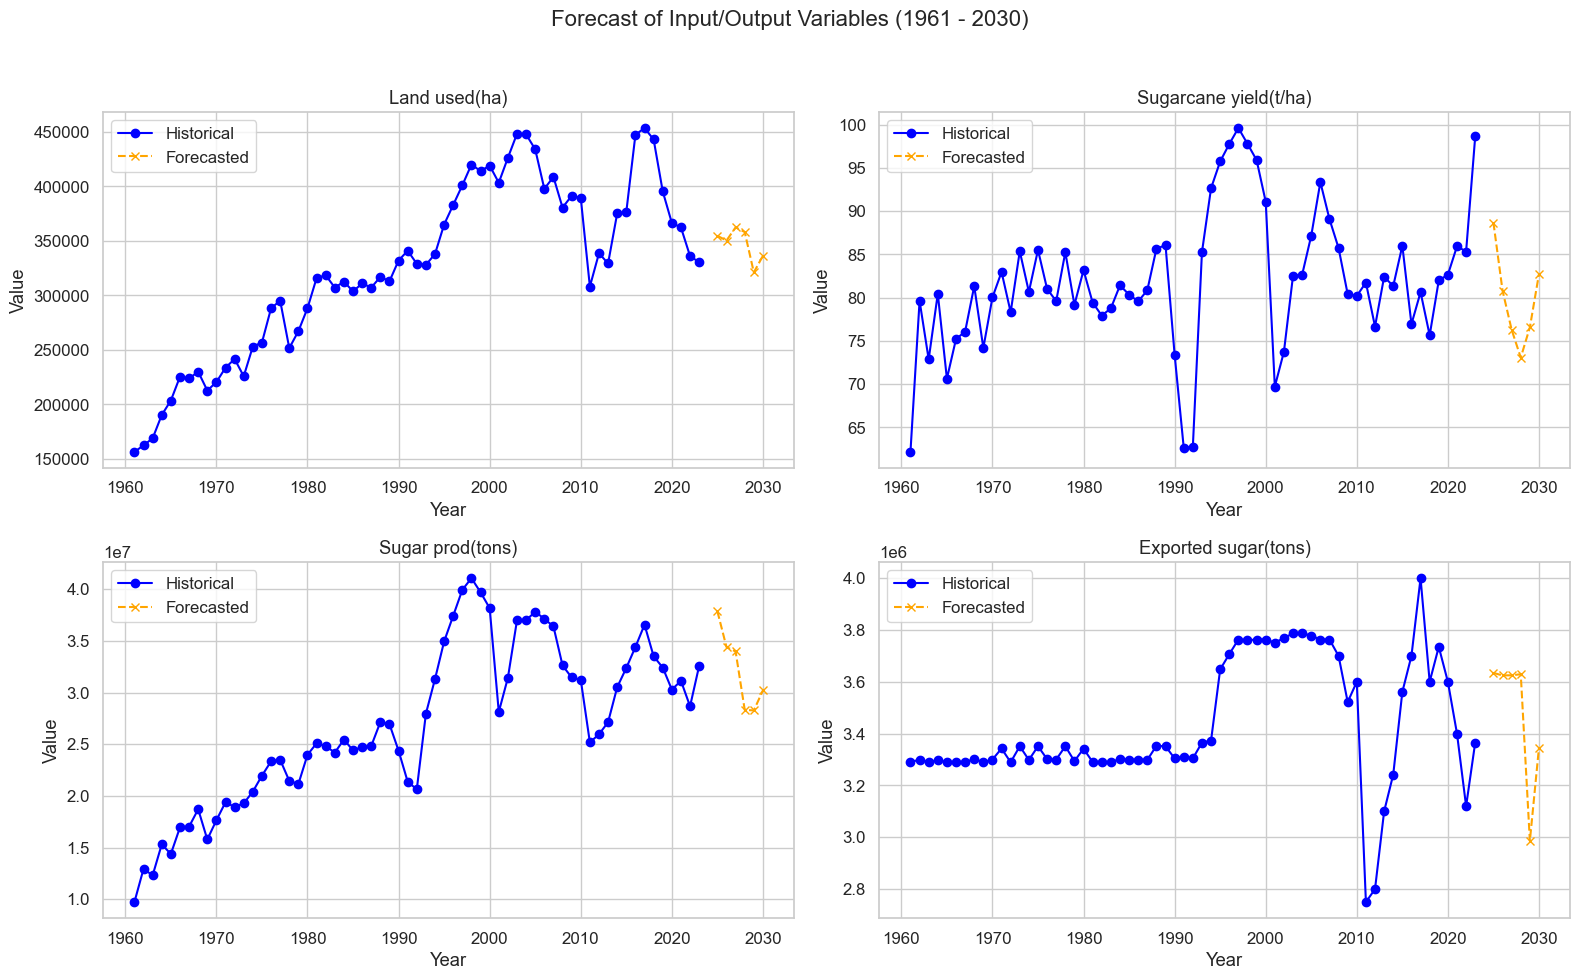

In [24]:
# PLOT THE FORECAST FOR ALL PARAMETERS (in this case 4)
import matplotlib.pyplot as plt

columns_to_plot = ["land_used(ha)", "sugarcane_yield(t/ha)", "sugar_prod(tons)", "exported_sugar(tons)"]

# Use is_forecast column as a split
historical = full_forecasted_df[full_forecasted_df["is_forecast"] == False]
forecasted = full_forecasted_df[full_forecasted_df["is_forecast"] == True]

plt.figure(figsize=(16, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    
    plt.plot(historical["year"], historical[col], label="Historical", color="blue", marker='o')
    plt.plot(forecasted["year"], forecasted[col], label="Forecasted", color="orange", linestyle='--', marker='x')
    
    plt.title(col.replace("_", " ").capitalize())
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

plt.suptitle("Forecast of Input/Output Variables ({} - {})".format(
    int(full_forecasted_df["year"].min()), int(full_forecasted_df["year"].max())
), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## FORECASTING EVALUATION

To check whether the models work correctly, we will try to forecast the data which is already available

In [37]:
# Forecasting parameters
forecast_years = 25
window_size = 5
last_year = 1999

# Start window: last 5 years of raw data (only input columns)
future_input = df[df["year"] <= last_year][input_cols].iloc[-window_size:].copy().values
future_years = []
predictions = []

# Scale the input window just once
future_input_scaled = input_scaler.transform(future_input)

for step in range(forecast_years):
    # Flatten and predict
    model_input = future_input_scaled.reshape(1, -1)  # XGBoost expects flat input
    y_next = xgb.predict(model_input)[0]

    # Save predicted values directly
    predictions.append(y_next)
    future_years.append(int(last_year + step + 1))

    # Update future_input with new prediction (raw, unscaled)
    future_input = np.vstack([future_input[1:], y_next])  # raw values

    # Re-scale new input for next iteration
    future_input_scaled = input_scaler.transform(future_input)

# Forecasted DataFrame
future_df = pd.DataFrame(predictions, columns=input_cols)
future_df["year"] = future_years
future_df["is_forecast"] = True

# Merge with historical
historical_df = df.copy()
historical_df["is_forecast"] = False

full_forecasted_df = pd.concat([historical_df, future_df], ignore_index=True)

# Display
print("\nForecasted Data (last 25 years):")
display(full_forecasted_df.tail(13))


Forecasted Data (last 25 years):


,year,land_used(ha),sugarcane_yield(t/ha),sugar_prod(tons),exported_sugar(tons),is_forecast
75,2012,343321.93750,85.557358,34311340.0,3624274.50,True
76,2013,348478.50000,85.355194,34286512.0,3624245.50,True
77,2014,350262.65625,85.619865,34332576.0,3624840.00,True
78,2015,349901.00000,85.389236,34098344.0,3624309.00,True
79,2016,362544.71875,82.869614,34084096.0,3630313.00,True
80,2017,362234.96875,83.893135,34089236.0,3625436.75,True
81,2018,361595.25000,85.500244,34079236.0,3624629.75,True
82,2019,361572.65625,85.536499,34079028.0,3624682.75,True
83,2020,362478.53125,85.631012,34096008.0,3625705.25,True
84,2021,362553.56250,85.535942,34096008.0,3625078.75,True


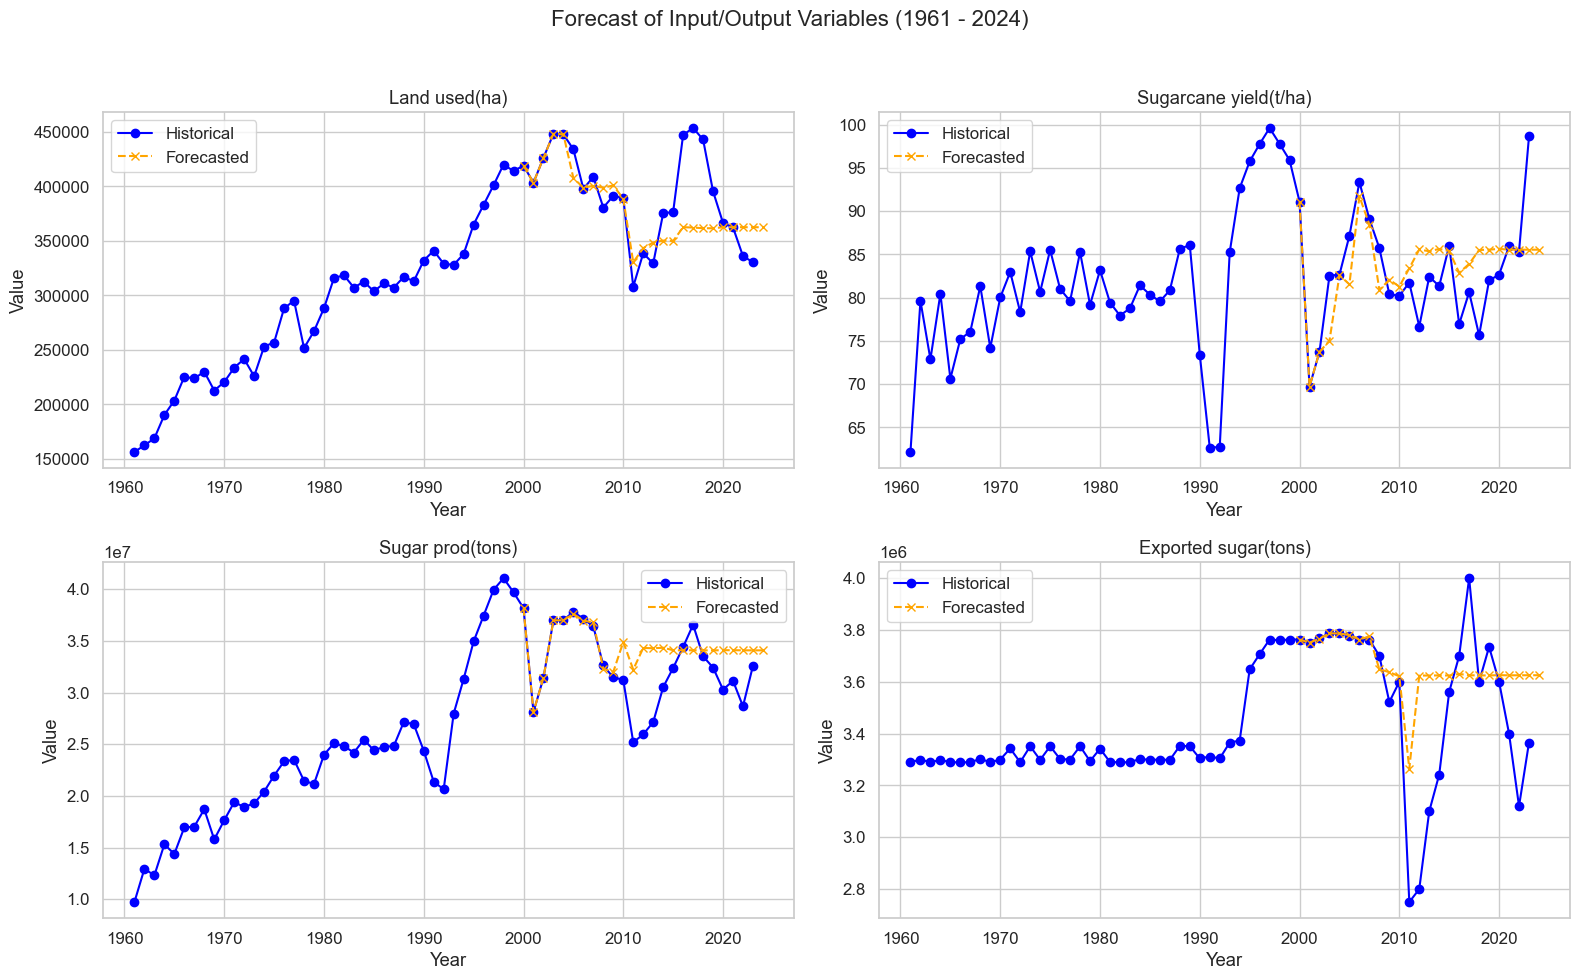

In [38]:
# PLOT THE FORECAST FOR ALL PARAMETERS (in this case 4)
import matplotlib.pyplot as plt

columns_to_plot = ["land_used(ha)", "sugarcane_yield(t/ha)", "sugar_prod(tons)", "exported_sugar(tons)"]

# Use is_forecast column as a split
historical = full_forecasted_df[full_forecasted_df["is_forecast"] == False]
forecasted = full_forecasted_df[full_forecasted_df["is_forecast"] == True]

plt.figure(figsize=(16, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    
    plt.plot(historical["year"], historical[col], label="Historical", color="blue", marker='o')
    plt.plot(forecasted["year"], forecasted[col], label="Forecasted", color="orange", linestyle='--', marker='x')
    
    plt.title(col.replace("_", " ").capitalize())
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

plt.suptitle("Forecast of Input/Output Variables ({} - {})".format(
    int(full_forecasted_df["year"].min()), int(full_forecasted_df["year"].max())
), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Keep year column for proper alignment
actual = historical_df[historical_df["year"].between(2000, 2024)].reset_index(drop=True)
predicted = future_df[future_df["year"].between(2000, 2024)].reset_index(drop=True)

# Get common years
common_years = sorted(set(actual["year"]).intersection(set(predicted["year"])))

# Filter by common years
actual_filtered = actual[actual["year"].isin(common_years)].reset_index(drop=True)
predicted_filtered = predicted[predicted["year"].isin(common_years)].reset_index(drop=True)

# Calculate metrics
for col in input_cols:
    print(f"\n{col}:")
    print(f"RMSE: {mean_squared_error(actual_filtered[col], predicted_filtered[col], squared=False):,.2f}")
    print(f"MAE : {mean_absolute_error(actual_filtered[col], predicted_filtered[col]):,.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(actual_filtered[col], predicted_filtered[col]) * 100:.2f}%")


land_used(ha):
RMSE: 34,406.26
MAE : 21,497.20
MAPE: 5.36%

sugarcane_yield(t/ha):
RMSE: 4.85
MAE : 3.37
MAPE: 4.05%

sugar_prod(tons):
RMSE: 3,330,016.67
MAE : 2,170,080.75
MAPE: 7.54%

exported_sugar(tons):
RMSE: 282,678.99
MAE : 171,211.06
MAPE: 5.44%


c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Mugilkrishna D U\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To cal

In [40]:
# Forecasting parameters
forecast_years = 24
window_size = 5
last_year = 1999

# Start window: last 5 years of raw data (only input columns)
future_input = df[df["year"] <= last_year][input_cols].iloc[-window_size:].copy().values
future_years = []
predictions = []

# Scale the input window just once
future_input_scaled = input_scaler.transform(future_input)

for step in range(forecast_years):
    # Flatten and predict
    model_input = future_input_scaled.reshape(1, -1)  # Extra Trees expects flat input
    y_next = et.predict(model_input)[0]

    # Save predicted values directly
    predictions.append(y_next)
    future_years.append(int(last_year + step + 1))

    # Update future_input with new prediction (raw, unscaled)
    future_input = np.vstack([future_input[1:], y_next])  # raw values

    # Re-scale new input for next iteration
    future_input_scaled = input_scaler.transform(future_input)

# Forecasted DataFrame
future_df = pd.DataFrame(predictions, columns=input_cols)
future_df["year"] = future_years
future_df["is_forecast"] = True

# Merge with historical
historical_df = df.copy()
historical_df["is_forecast"] = False

full_forecasted_df = pd.concat([historical_df, future_df], ignore_index=True)

# Display
print("\nForecasted Data (last 25 years):")
display(full_forecasted_df.tail(25))


Forecasted Data (last 25 years):


,year,land_used(ha),sugarcane_yield(t/ha),sugar_prod(tons),exported_sugar(tons),is_forecast
62,2023,330456.00,98.619510,32589392.00,3.365660e+06,False
63,2000,419000.00,91.085205,38164690.00,3.763253e+06,True
64,2001,403324.00,69.713104,28116956.00,3.751270e+06,True
65,2002,426159.00,73.738600,31424352.00,3.768630e+06,True
66,2003,448189.00,82.543304,36994996.00,3.787303e+06,True
67,2004,447644.00,82.640305,36993456.00,3.787303e+06,True
68,2005,433953.00,87.157300,37822190.00,3.778433e+06,True
69,2006,397745.00,93.346504,37128108.00,3.763253e+06,True
70,2007,408624.00,89.072105,36396996.00,3.763253e+06,True
71,2008,380543.00,85.722500,32621112.00,3.700000e+06,True


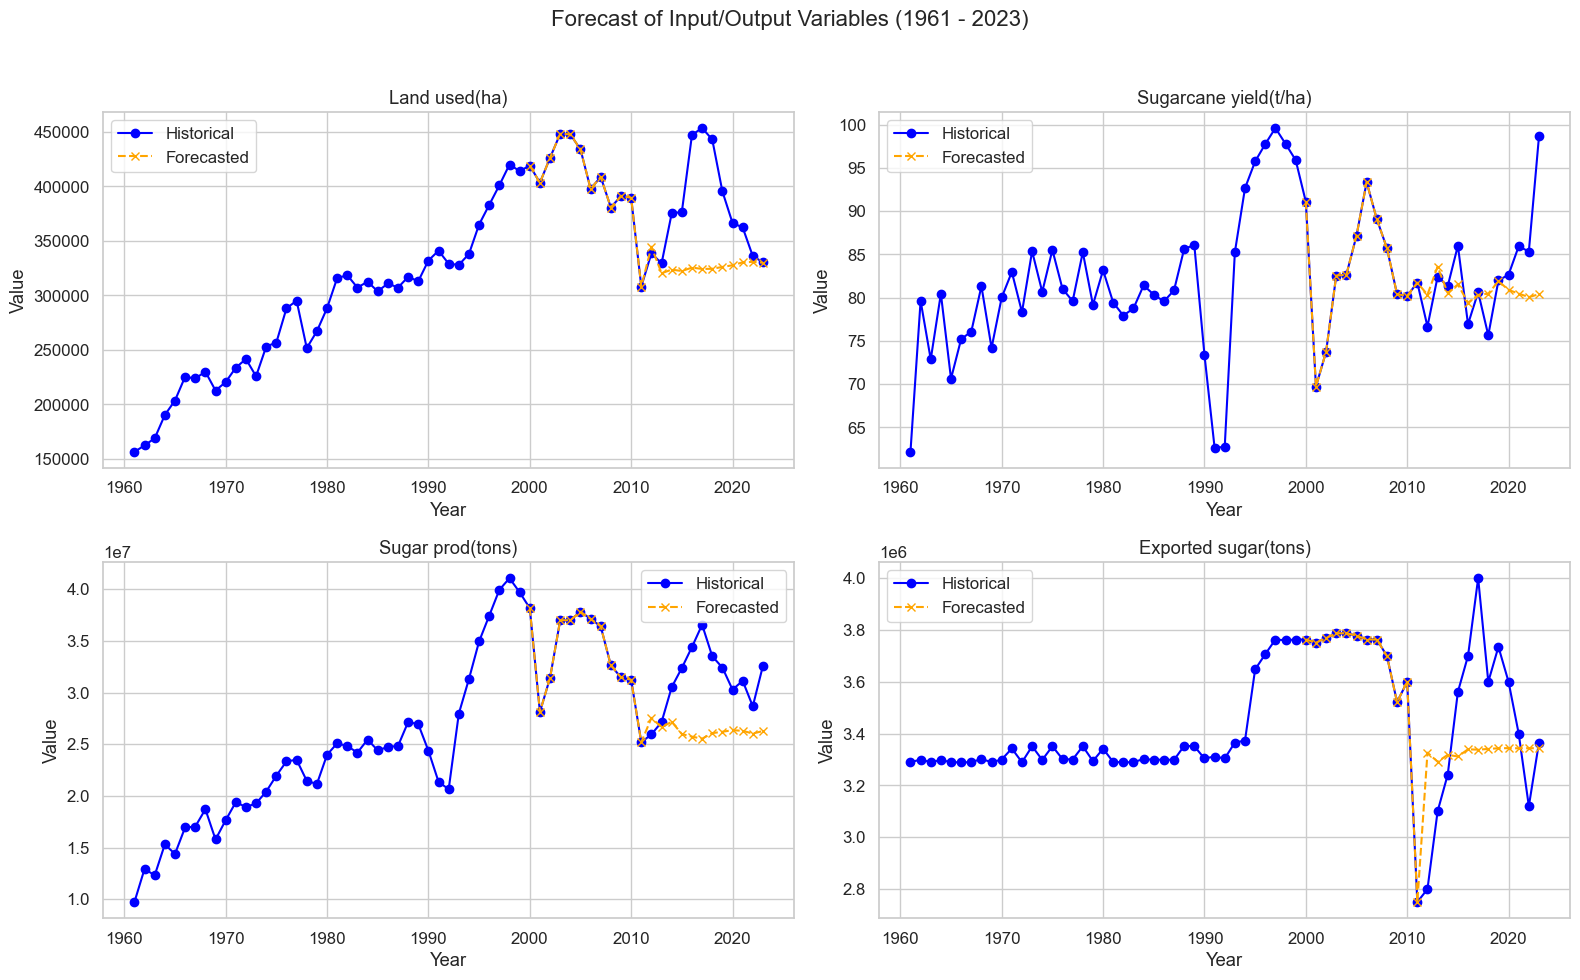

In [41]:
# PLOT THE FORECAST FOR ALL PARAMETERS (in this case 4)
import matplotlib.pyplot as plt

columns_to_plot = ["land_used(ha)", "sugarcane_yield(t/ha)", "sugar_prod(tons)", "exported_sugar(tons)"]

# Use is_forecast column as a split
historical = full_forecasted_df[full_forecasted_df["is_forecast"] == False]
forecasted = full_forecasted_df[full_forecasted_df["is_forecast"] == True]

plt.figure(figsize=(16, 10))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    
    plt.plot(historical["year"], historical[col], label="Historical", color="blue", marker='o')
    plt.plot(forecasted["year"], forecasted[col], label="Forecasted", color="orange", linestyle='--', marker='x')
    
    plt.title(col.replace("_", " ").capitalize())
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

plt.suptitle("Forecast of Input/Output Variables ({} - {})".format(
    int(full_forecasted_df["year"].min()), int(full_forecasted_df["year"].max())
), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## DEA EFFICIENCY CALCULATION

In [30]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value
import numpy as np
import matplotlib.pyplot as plt

# DEA efficiency
def dea_efficiency(inputs, outputs, ref_inputs, ref_outputs, vrs=False):
    """
    DEA efficiency using CRS or VRS.
    vrs=True → Variable Returns to Scale (adds convexity constraint)
    """
    n_ref = ref_inputs.shape[0]
    n_out = outputs.shape[0]

    prob = LpProblem("DEA", LpMaximize)
    lambdas = [LpVariable(f"λ_{i}", lowBound=0) for i in range(n_ref)]
    theta = LpVariable("θ", lowBound=0)

    prob += theta, "Objective"

    # Output constraints
    for r in range(n_out):
        prob += lpSum([lambdas[i] * ref_outputs[i][r] for i in range(n_ref)]) >= theta * outputs[r]

    # Input constraints
    for r in range(inputs.shape[0]):
        prob += lpSum([lambdas[i] * ref_inputs[i][r] for i in range(n_ref)]) <= inputs[r]

    # VRS constraint (convexity: sum λ = 1)
    if vrs:
        prob += lpSum(lambdas) == 1

    prob.solve()
    return value(theta)

# Malmquist Index Calculation
def malmquist_index_extended(data, input_cols, output_cols):
    ec_scores, tc_scores, tfp_scores = [], [], []
    pec_scores, sec_scores = [], []

    full_ref_X = data[input_cols].values
    full_ref_Y = data[output_cols].values

    for t in range(len(data) - 1):
        X_t   = data[input_cols].iloc[t].values
        X_tp1 = data[input_cols].iloc[t+1].values
        Y_t   = data[output_cols].iloc[t].values
        Y_tp1 = data[output_cols].iloc[t+1].values

        # Evaluate against global reference frontier (all DMUs/years)
        eff_tt    = dea_efficiency(X_t,    Y_t,    full_ref_X, full_ref_Y, vrs=False)
        eff_tp1   = dea_efficiency(X_tp1,  Y_tp1,  full_ref_X, full_ref_Y, vrs=False)
        eff_tt_v  = dea_efficiency(X_t,    Y_t,    full_ref_X, full_ref_Y, vrs=True)
        eff_tp1_v = dea_efficiency(X_tp1,  Y_tp1,  full_ref_X, full_ref_Y, vrs=True)

        # Cross-period frontiers
        eff_tp1_t = dea_efficiency(X_tp1,  Y_tp1,  full_ref_X, full_ref_Y, vrs=False)
        eff_t_tp1 = dea_efficiency(X_t,    Y_t,    full_ref_X, full_ref_Y, vrs=False)

        eff_tt  = np.clip(eff_tt,  1e-8, None)
        eff_tp1 = np.clip(eff_tp1, 1e-8, None)
        eff_tt_v  = np.clip(eff_tt_v,  1e-8, None)
        eff_tp1_v = np.clip(eff_tp1_v, 1e-8, None)

        ec  = eff_tp1 / eff_tt
        tc  = np.sqrt((eff_tp1_t / eff_tp1) * (eff_t_tp1 / eff_tt))
        tfp = ec * tc
        pec = eff_tp1_v / eff_tt_v
        sec = ec / pec

        ec_scores.append(ec)
        tc_scores.append(tc)
        tfp_scores.append(tfp)
        pec_scores.append(pec)
        sec_scores.append(sec)

    return ec_scores, tc_scores, tfp_scores, pec_scores, sec_scores

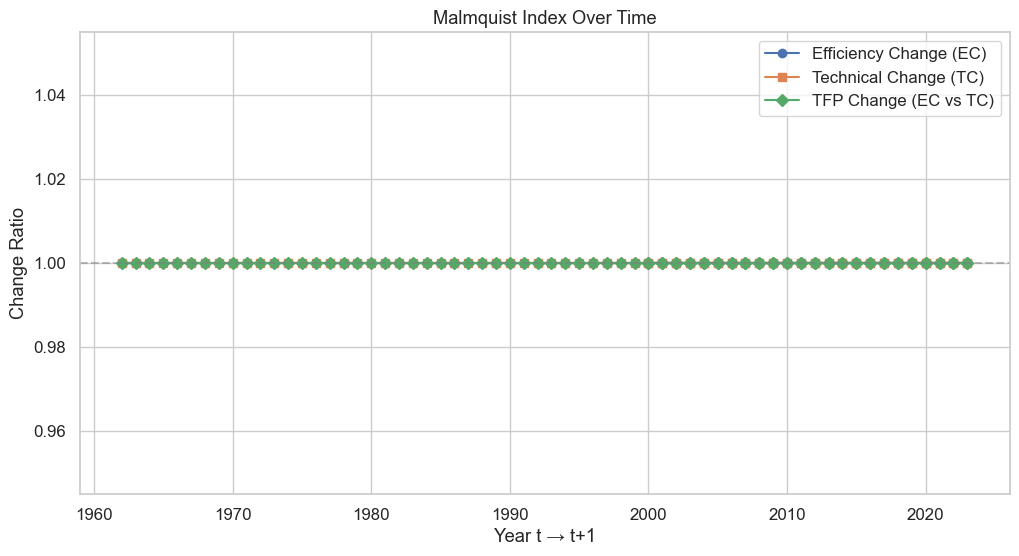

In [31]:
# Plot Malmquist
def plot_malmquist(ec, tc, tfp, years):
    """
    Visualizes Malmquist index components over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(years, ec, label="Efficiency Change (EC)", marker="o")
    plt.plot(years, tc, label="Technical Change (TC)", marker="s")
    plt.plot(years, tfp, label="TFP Change (EC vs TC)", marker="D")
    plt.axhline(1.0, linestyle="--", color="gray", alpha=0.5)
    plt.title("Malmquist Index Over Time")
    plt.xlabel("Year t → t+1")
    plt.ylabel("Change Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

ec, tc, tfp, pec, sec = malmquist_index_extended(full_forecasted_df, input_cols, input_cols)

years = full_forecasted_df["year"].iloc[1:].tolist()

plot_malmquist(ec, tc, tfp, years)

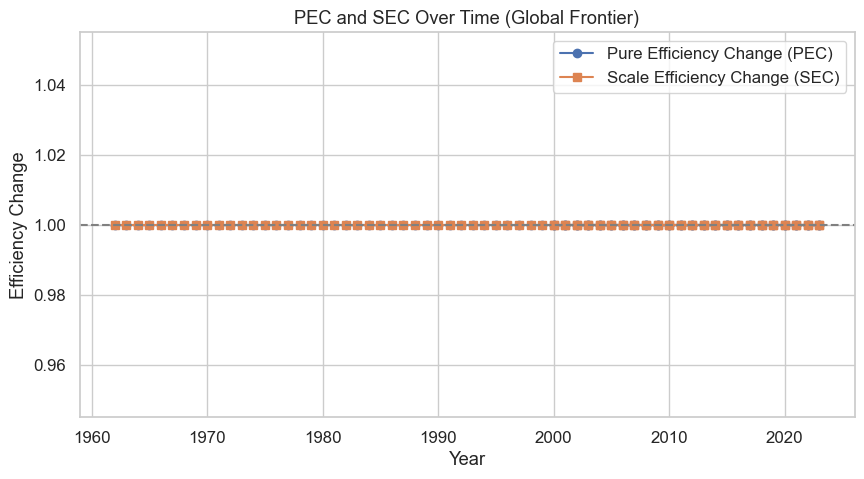

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(years, pec, label="Pure Efficiency Change (PEC)", marker='o')
plt.plot(years, sec, label="Scale Efficiency Change (SEC)", marker='s')
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("PEC and SEC Over Time (Global Frontier)")
plt.xlabel("Year")
plt.ylabel("Efficiency Change")
plt.grid(True)
plt.legend()
plt.show()